In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage import gaussian_filter

rawECB = pd.read_pickle('C:/Users/annas/OneDrive/Cambridge/WORK/BAS/PYTHON/ECB_raw.pkl')
ECBraw = rawECB.reset_index()
# Average spatially all 40 years, remove 29th Feb, organise in columns per year

grouped_DoY = ECBraw.groupby('time')
average_day_sst = grouped_DoY.mean()
average_day_sst = average_day_sst.reset_index()

sst_groupby_yr = {}

for i in range(1982, 2022):
    t_evolution = average_day_sst[(average_day_sst['time'] >= f"{i}-01-01") & (average_day_sst['time'] <= f"{i}-12-31")]
    t_evolution = t_evolution[t_evolution['time'] != f"{i}-02-29"]
    sst_groupby_yr[f'sst_{i}'] = t_evolution['analysed_sst'].reset_index()['analysed_sst']

year_col_sst = pd.DataFrame.from_dict(sst_groupby_yr) 

In [173]:
anoms_dict = {}
bg_climat_dict = {}

for i in range(0, 20):
    times = pd.date_range(f'{1982+i}-01-01', f'{1982+i+19}-12-31', freq='D')

    ECBraw['time'] = pd.to_datetime(ECBraw['time'])
    avgs = ECBraw.groupby('time')['analysed_sst'].mean().reindex(times, fill_value=None)

    dict = {'date': times, 'avg_t': avgs}  
    bg_timeseries = pd.DataFrame(dict)

    bg_timeseries['year'] = bg_timeseries['date'].dt.year
    bg_timeseries['month'] = bg_timeseries['date'].dt.month
    bg_timeseries['day'] = bg_timeseries['date'].dt.day
    bg_timeseries = bg_timeseries.loc[~((bg_timeseries['month'] == 2) & (bg_timeseries['day'] == 29))]

    # Apply smoothing filter, create new dataframe
    day = pd.date_range(f'{1982+i}-01-01', f'{1982+i+19}-12-31', freq='D')
    day_no_feb29 = day[~((day.month == 2) & (day.day == 29))]
    sigma = 30
    smoothed_avgs = gaussian_filter(bg_timeseries['avg_t'].to_list(), sigma=sigma)
    dict2 = {'date': day_no_feb29, 'avg_t': smoothed_avgs} 
    smooth_bg_timeseries = pd.DataFrame(dict2)
    smooth_bg_timeseries['year'] = smooth_bg_timeseries['date'].dt.year

    ###

    # Split into columns for each year 1990-2010

    year = np.arange(1982+i, 1982+i+20)
    dict3 = {}
    for j in range(len(year)):
        sst = smooth_bg_timeseries.query(f"year == {year[j]}")['avg_t'].values
        dict3[f'sst_{year[j]}'] = sst
    bg = pd.DataFrame(dict3)

    # Average across each calander day 

    bg['mean'] = bg.mean(axis=1)
    bg['Q90'] = bg.apply(lambda row: np.percentile(row.drop('mean'), 90), axis=1)

    bg_climat_dict[f'bg_{1982+i+20}'] = bg['mean'] - 273.15

    ###

    sstdiff_gb_yr = {}

    m = 1982+20+i

    diff = year_col_sst[f'sst_{m}'] - bg['mean']
    sstdiff_gb_yr[f'diff_{m}'] = diff

    difference = pd.DataFrame.from_dict(sstdiff_gb_yr)     
    difference['mean'] = bg['mean'] - 273.15
    difference['Q90'] = bg['Q90'] - bg['mean']

    ###

    std_diff = []
    for i in range(len(difference['Q90'])):
        if difference[f'diff_{m}'].iloc[i] >= 0:
            diff = difference[f'diff_{m}'].iloc[i] - difference['Q90'].iloc[i]
            if diff > 0:
                std_diff.append(diff)
            else:
                std_diff.append(np.nan)
        else:
            diff = - difference[f'diff_{m}'].iloc[i] - difference['Q90'].iloc[i]
            if diff > 0:
                std_diff.append(-diff)
            else:
                std_diff.append(np.nan)
    anoms_dict[f'std_diff{m}'] = std_diff 

times = pd.date_range('1982-01-01', '1982-12-31', freq='D')  
dict['date'] = times

anoms = pd.DataFrame(anoms_dict)

In [165]:
bg_climats = pd.DataFrame(bg_climat_dict)

In [174]:
# Finding anaomaly dates - merging events that have less than 5 day gap inbetween 

from collections import deque

start_d = []
end_d = []

years = np.arange(2002, 2022)

for i in range(2002, 2022):
    yrlist = list(anoms[f'std_diff{i}'])

    yrlistp = deque([np.nan if x < 0 else x for x in yrlist])
    yrlistp.appendleft(np.nan)

    indvals = []
    for m in range(len(yrlistp)):
        if np.isnan(yrlistp[m-1]):
            if not np.isnan(yrlistp[m]):
                indvals.append(m)

    start_day = []
    end_day = []

    for k in range(len(indvals)):
        arr_here = []
        for j in range(len(yrlistp)-indvals[k]):
            if not np.isnan(yrlistp[indvals[k]+j]):
                arr_here.append(yrlistp[indvals[k]+j])
            if np.isnan(yrlistp[indvals[k]+j]):
                break
        if len(arr_here) > 4:
            start_day.append(indvals[k]-1)
            end_day.append(indvals[k]+len(arr_here)-1)
    start_d.append(start_day)
    end_d.append(end_day)

dict = {'year': years, 'startdate': start_d, 'enddate': end_d}

start_end = pd.DataFrame.from_dict(dict)

breaks = []
for i in range(len(years)):
    starts = start_end.loc[start_end['year'] == years[i], 'startdate'].values[0]
    ends = start_end.loc[start_end['year'] == years[i], 'enddate'].values[0]
    br = []
    for j in range(len(starts)-1):
        diff = starts[j+1] - ends[j]
        br.append(diff)
    breaks.append(br)

start_end['breaks'] = breaks

new_start = []
new_end = []

for m in range(len(years)):
    Breaks = start_end.loc[start_end['year'] == years[m], 'breaks'].values[0]
    starts = start_end.loc[start_end['year'] == years[m], 'startdate'].values[0]
    ends = start_end.loc[start_end['year'] == years[m], 'enddate'].values[0]

    for k in range(len(Breaks)):
        if Breaks[k] < 5:
            ends[k] = np.nan
            starts[k+1] = np.nan

    new_start.append([x for x in starts if not (isinstance(x, float) and math.isnan(x))])
    new_end.append([x for x in ends if not (isinstance(x, float) and math.isnan(x))])


dict = {}
dict['year'] = start_end['year']
dict['starts'] = new_start
dict['ends'] = new_end

new_start_end = pd.DataFrame.from_dict(dict)

In [177]:
new_start_end['duration'].iloc[19]

[8, 76]

In [179]:
count = []
for i in range(0,20):
    for j in range(len(new_start_end['starts'].iloc[i])):
        count.append(new_start_end['duration'].iloc[i][j])

print(len(count))

42


In [176]:
all_max_int = []
all_avg_int = []
all_duration = []
all_peaks = []
year_here = []

for i in range(len(years)):
    max_i = []
    avg_i = []
    dur = []
    year_Here = []
    peak_day = []
    for j in range(len(new_start_end.loc[new_start_end['year'] == years[i], 'starts'].values[0])):
        temp_excess = []
        start = new_start_end.loc[new_start_end['year'] == years[i], 'starts'].values[0][j]
        end = new_start_end.loc[new_start_end['year'] == years[i], 'ends'].values[0][j]
        for m in range(start, end):
            temp_excess.append(anoms[f'std_diff{years[i]}'].iloc[m])
        max_i.append(np.nanmax(temp_excess))
        avg_i.append(np.nanmean(temp_excess))
        dur.append(len(temp_excess))
        peak_day.append(np.nanargmax(temp_excess)+new_start_end.loc[new_start_end['year'] == years[i], 'starts'].values[0][j])
        year_Here.append(years[i])

    all_max_int.append(max_i)
    all_avg_int.append(avg_i)
    all_duration.append(dur)
    all_peaks.append(peak_day)
    year_here.append(year_Here)

new_start_end['max_i'] = all_max_int
new_start_end['avg_i'] = all_avg_int
new_start_end['duration'] = all_duration
new_start_end['peak_day'] = all_peaks
new_start_end['year_here'] = year_here

difference['Q902'] = difference['Q90']*2
difference['Q903'] = difference['Q90']*3
difference['Q904'] = difference['Q90']*4

In [161]:
peak_intensity = []

for i in range(len(years)):
    peak_here = []
    for j in range(len(new_start_end['peak_day'].iloc[i])):
        peak_ints = (new_start_end['max_i']).iloc[i][j]

        peak_int = (new_start_end['peak_day']).iloc[i][j]
        q901 = difference['Q90'].iloc[peak_int]
        q902 = difference['Q902'].iloc[peak_int]
        q903 = difference['Q903'].iloc[peak_int]
        q904 = difference['Q904'].iloc[peak_int]

        if 0 <= peak_ints < q901:
            peak_here.append('Moderate')
        if q901 <= peak_ints < q902:
            peak_here.append('Strong')
        if q902 <= peak_ints < q903:
            peak_here.append('Severe')
        if q903 <= peak_ints:
            peak_here.append('Extreme')

    peak_intensity.append(peak_here)

new_start_end['intensity_cat'] = peak_intensity

In [162]:
count = []
for i in range(0,20):
    for j in range(len(new_start_end['starts'].iloc[i])):
        count.append(new_start_end['starts'].iloc[i][j])


print(len(count))

42


(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300'),
  Text(350.0, 0, '350'),
  Text(400.0, 0, '400')])

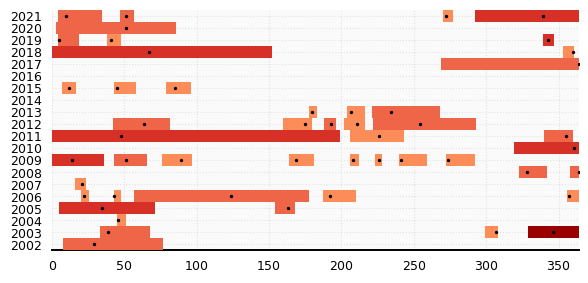

In [148]:
from matplotlib.patches import Rectangle
colors = ['#990000','#d73027','#ef6548', '#fc8d59']

peakdaypW = [item for sublist in new_start_end['peak_day'] for item in sublist]
yrW = np.array([item for sublist in new_start_end['year_here'] for item in sublist])

startday = np.array([item for sublist in new_start_end['starts'] for item in sublist])
duration = np.array([item for sublist in new_start_end['duration'] for item in sublist])

plt.figure(figsize=(6,3))

ax = plt.gca()
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines[['bottom']].set_linewidth(1.4)
plt.tick_params(left = False)
plt.tick_params(bottom = False)

plt.tight_layout()
ax.set_facecolor('#FAFAFA')
plt.grid( linestyle='dotted', color='#ccc', zorder=1, alpha=0.5)

plt.tight_layout()
#plt.grid(zorder=1, linestyle='dotted', alpha=0.5)
#plt.title('Western Core Box', fontweight = 'bold', loc='left', y=1.01, fontsize=14)
#plt.xlabel('Day of Year')
#plt.ylabel('Year')
plt.xlim(0,364)
plt.ylim(2001.5, 2021.5)
#plt.yticks(years, fontsize=5)

for i in range(0,20):
    y = years[i]
    starts = new_start_end['starts'].loc[i]
    dur = new_start_end['duration'].loc[i]
    inten = new_start_end['avg_i'].loc[i]

    for m in range(len(dur)):
        y_min = y - 0.5
        x_min = starts[m]
        y_len = 1
        x_len = dur[m]
        intensity = inten[m]

        if new_start_end['intensity_cat'].loc[i][m] == 'Moderate':
            colour = colors[3]
        if new_start_end['intensity_cat'].loc[i][m] == 'Strong':
            colour = colors[2]
        if new_start_end['intensity_cat'].loc[i][m] == 'Severe':
            colour = colors[1]
        if new_start_end['intensity_cat'].loc[i][m] == 'Extreme':
            colour = colors[0]

        ax.add_patch(Rectangle((x_min, y_min), x_len, y_len, fc =colour,lw = 0, zorder=5))

plt.scatter(peakdaypW, yrW, c='k', s=2, zorder=10)
plt.yticks(years, fontsize=9)
plt.xticks(fontsize=9)

In [149]:
gradient_colors = [
    # Rich Blues
    "#041F3F",  # Midnight Blue
    "#062E5A",  # Deep Indigo-Blue
    "#0A4174",  # Navyish Blue
    "#104E8A",  # Rich Blue
    "#175CA0",  # Deep Cobalt
    "#1F6BB5",  # Muted Azure

    # Purples / Violets
    "#2A7CCC",  # Soft Sapphire
    "#3C78C7",  # Cool Blue-Violet
    "#5073C3",  # Periwinkle Blue
    "#636EBD",  # Lavender Indigo
    "#7769B4",  # Dusty Purple
    "#8B64AA",  # Muted Violet
    "#A65F95",  # Mauve
    "#C05A7C",  # Plum Rose

    # Rich Reds
    "#E75C5C",  # Dusty Rose Red
    "#D94848",  # Warm Ruby
    "#C73737",  # Classic Crimson
    "#B82C2C",  # Rich Cherry
    "#A12323",  # Deep Red
    "#8B1A1A",  # Dark Crimson
]



(-0.2, 3.8)

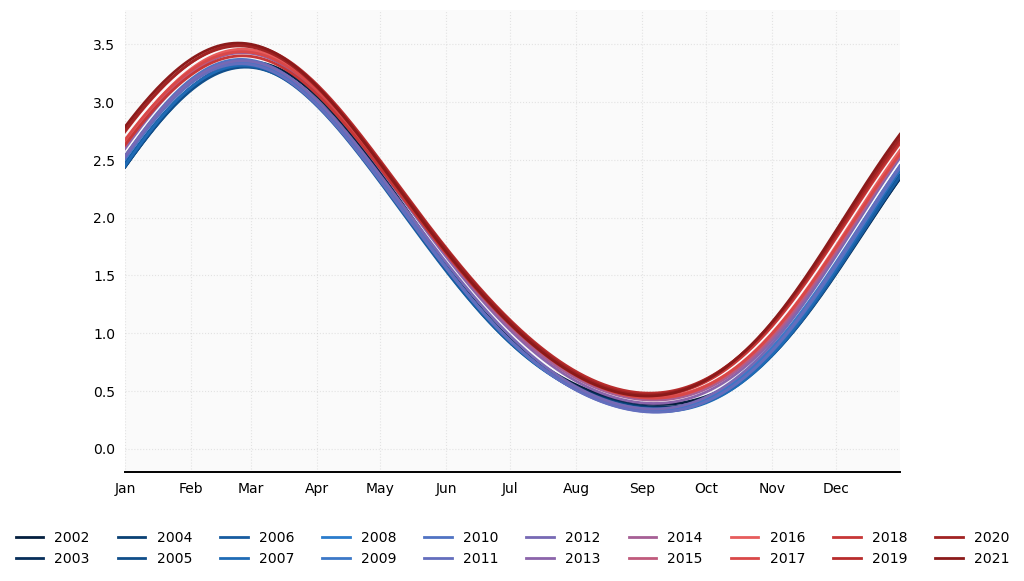

In [151]:
import matplotlib.dates as mdates

times = pd.date_range('1990-01-01', '1990-12-31', freq='D')

plt.figure(figsize=(10,6))

ax= plt.gca()

ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines[['bottom']].set_linewidth(1.4)
plt.tick_params(left = False)
plt.tick_params(bottom = False)
ax.set_facecolor('#FAFAFA')
plt.grid(linestyle='dotted', color='#ccc', zorder=1, alpha=0.5)

for i in range(2002, 2022):
    plt.plot(times, bg_climats[f'bg_{i}'], color=gradient_colors[i-2002], linewidth=2, label=f'{i}')

plt.xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('1990-12-31'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=10, frameon=False)

plt.ylim(-0.2, 3.8)

In [181]:
### Defining event intensities

# Multiples of 90th percentile
difference['Q902'] = difference['Q90']*2
difference['Q903'] = difference['Q90']*3
difference['Q904'] = difference['Q90']*4

# Find which range the peak intensity lies in
peak_intensity = []

for i in range(len(years)):
    peak_here = []
    for j in range(len(new_start_end['peak_day'].iloc[i])):
        peak_ints = (new_start_end['max_i']).iloc[i][j]

        peak_int = (new_start_end['peak_day']).iloc[i][j]
        q901 = difference['Q90'].iloc[peak_int]
        q902 = difference['Q902'].iloc[peak_int]
        q903 = difference['Q903'].iloc[peak_int]
        q904 = difference['Q904'].iloc[peak_int]

        if 0 <= peak_ints < q901:
            peak_here.append('Moderate')
        if q901 <= peak_ints < q902:
            peak_here.append('Strong')
        if q902 <= peak_ints < q903:
            peak_here.append('Severe')
        if q903 <= peak_ints:
            peak_here.append('Extreme')

    peak_intensity.append(peak_here)

new_start_end['intensity_cat'] = peak_intensity

In [183]:
count = []
for i in range(0,20):
    for j in range(len(new_start_end['starts'].iloc[i])):
        count.append(new_start_end['intensity_cat'].iloc[i][j])


print(count)

from collections import Counter
counts = Counter(count)
print(counts)

['Strong', 'Moderate', 'Moderate', 'Strong', 'Moderate', 'Severe', 'Moderate', 'Strong', 'Moderate', 'Moderate', 'Strong', 'Strong', 'Strong', 'Moderate', 'Moderate', 'Moderate', 'Extreme', 'Severe', 'Moderate', 'Strong', 'Moderate', 'Strong', 'Moderate', 'Moderate', 'Moderate', 'Strong', 'Strong', 'Strong', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Strong', 'Strong', 'Moderate', 'Moderate', 'Strong', 'Moderate', 'Strong', 'Moderate', 'Strong']
Counter({'Moderate': 23, 'Strong': 16, 'Severe': 2, 'Extreme': 1})
